# Rendering of Experimental Results

<Figure size 640x400 with 0 Axes>

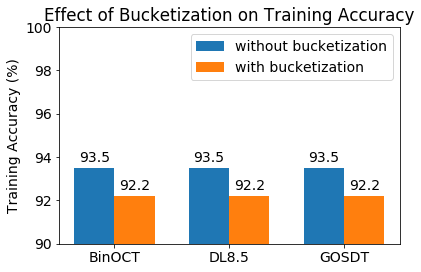

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import log
import pandas as pd
import numpy as np
import seaborn as sns
import re

results = pd.DataFrame(pd.read_csv('../experiments/results/optimality_example.csv'))

labels = ['BinOCT', 'DL8.5', 'GOSDT']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()

midpoints = ax.bar(x - width/2, 
                   results[results.discretization == "midpoints"]["training_accuracy(%)"],
                   width,
                   label="without bucketization")
bucketize = ax.bar(x + width/2, 
                   results[results.discretization == "bucketize"]["training_accuracy(%)"],
                   width,
                   label="with bucketization")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Accuracy (%)')
ax.set_title('Effect of Bucketization on Training Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(midpoints)
autolabel(bucketize)

fig.tight_layout()
plt.ylim(90,95)

plt.show()



In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits import mplot3d
from math import log
import pandas as pd
import numpy as np
import seaborn as sns
import re
plt.rc('font', size=18)
colors = ['#509eba', '#e3a042', '#d77ede', '#233c82', '#613717']
markers = ['o', 's', 'D', 'v', '^',]

x_axis = '# Leaves'
y_axis = 'Test Accuracy'

for dataset in ['car-evaluation', 'compas-binary','tic-tac-toe',
    'monk1-train','monk2-train','monk3-train']:
    plt.figure(figsize=(8, 5), dpi=80)

    results = pd.DataFrame(pd.read_csv('../experiments/trials/{}.csv'.format(dataset)))
    results = results[results['Training Time'] > 0][results['Training Time'] < 300][results['# Leaves'] <= 32]

    x_max = 0

    for i, algorithm in enumerate(sorted(set(results['Algorithm']))):
        data = results[results['Algorithm']==algorithm]

        x = []
        y = []
        x_low = []
        x_high = []
        y_low = []
        y_high = []

        errorboxes = []

        points = set()

        for depth, width, reg in sorted(set(tuple(row.tolist()) for row in data[['Depth Limit', 'Width Limit', 'Regularization']].values)):
            point_results = data[data['Depth Limit'] == depth][data['Width Limit'] == width][data['Regularization'] == reg]

            if len(point_results) <= 2:
                continue

            x_iqr = point_results[x_axis].quantile([0.25, 0.5, 0.75])
            y_iqr = point_results[y_axis].quantile([0.25, 0.5, 0.75])


            point = (x_iqr[0.5], y_iqr[0.5],
            x_iqr[0.5] - x_iqr[0.25], x_iqr[0.75] - x_iqr[0.5],
            y_iqr[0.5] - y_iqr[0.25], y_iqr[0.75] - y_iqr[0.5])

            if not point in points:
                points.add(point)
                x.append(point[0])
                y.append(point[1])
                x_low.append(point[2])
                x_high.append(point[3])
                y_low.append(point[4])
                y_high.append(point[5])

        for xv, yv, xl, xh, yl, yh in zip(x, y, x_low, x_high, y_low, y_high):
            rect = Rectangle((xv - xl, yv - yl), max(xl + xh, 0.00001), max(yl + yh, 0.00001))
            errorboxes.append(rect)

        if algorithm == 'gosdt':
            x_max = max(x)

        # # Create patch collection with specified colour/alpha
        # pc = PatchCollection(errorboxes, facecolor=colors[i], edgecolor=colors[i], alpha=0.0)
        # ax.add_collection(pc)
        
        plt.errorbar(x, y, xerr=[x_low, x_high], yerr=[y_low, y_high], label=algorithm,
        markersize=5, marker=markers[i], 
        color=colors[i], alpha=0.75,
        linewidth=1, linestyle='none')

        # plt.xscale('log')
    # plt.margins(10, 10)
    plt.xlabel('Number of Leaves')
    plt.ylabel(y_axis + " (%)")
    # plt.xlim(0, min(x_max + 1, 100))
    if dataset == 'monk3-train':
        plt.legend(loc='lower right')
    plt.title("{} vs Number of Leaves\n({})".format(y_axis, dataset))
    # plt.show()
    plt.savefig("test_accuracy_vs_leaves_{}.png".format(dataset), bbox_inches='tight')

FileNotFoundError: [Errno 2] File b'../experiments/trials/car-evaluation.csv' does not exist: b'../experiments/trials/car-evaluation.csv'

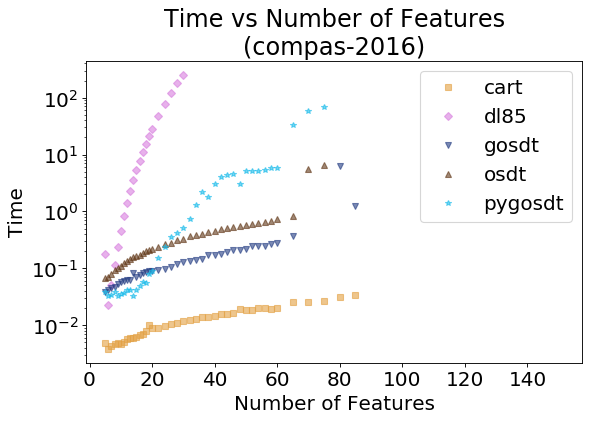

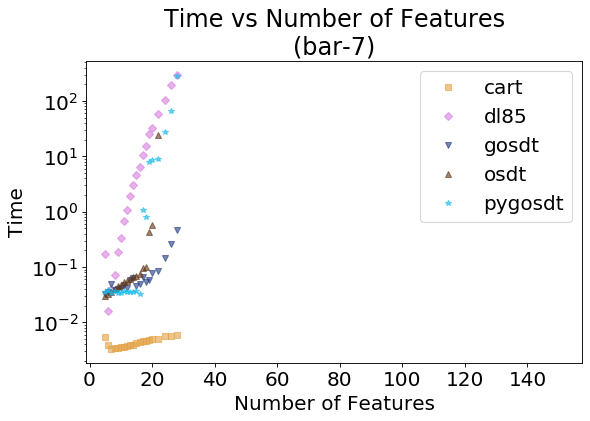

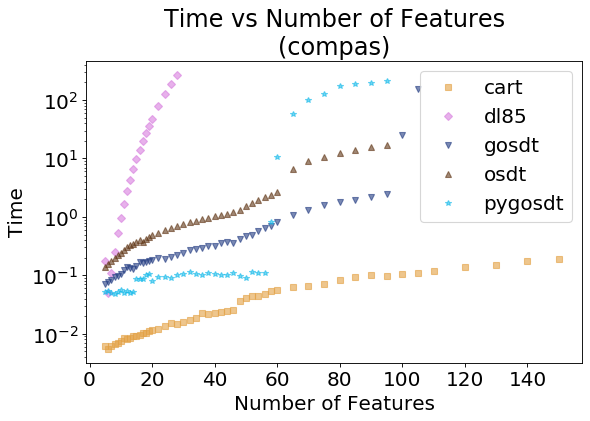

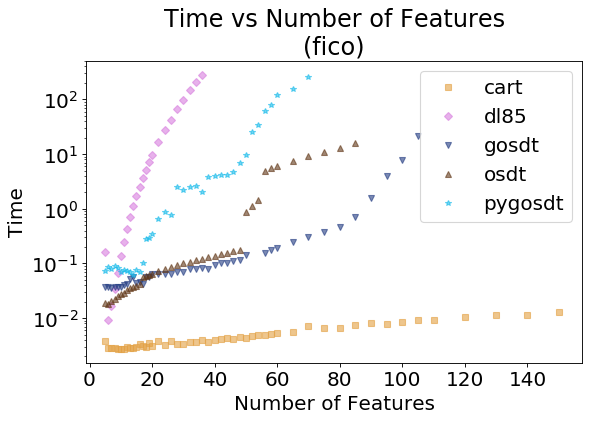

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from math import log
import pandas as pd
import numpy as np
import seaborn as sns
import re
plt.rc('font', size=18)
colors = ['#509eba', '#e3a042', '#d77ede', '#233c82', '#613717', '#16baea']
markers = ['o', 's', 'D', 'v', '^', '*', 'o', 's', 'D', 'v', '^']

algorithms = ['cart', 'binoct', 'dl85', 'osdt', 'gosdt', 'pygosdt']

datasets = ['compas-2016', 'bar-7', 'compas', 'fico']

scaling_factor = 'features'
x_axis = 'binary_features'

# scaling_factor = 'samples'
# x_axis = 'samples'

y_axis = 'training time'
y_label = 'Time'

time_limit = 300

for dataset in datasets:
    plt.figure(figsize=(8, 5), dpi=80)

    train = []
    test = []
    n = 0
    algs = []
    for algorithm in sorted(set(algorithms)):
        data = pd.DataFrame(pd.read_csv('../archive/results/{}_{}_{}.csv'.format(scaling_factor, dataset, algorithm)))
        if data[data['time'] > 0][data['time'] < time_limit].shape[0] == 0:
            algs.append(algorithm)
            train.append(data['training'])
            test.append(data['test'])
            n = max(n, len(data['training']))
            continue
        algs.append(algorithm)
        train.append(data['training'])
        test.append(data['test'])
        n = max(n, len(data['training']))

    train_max = [0] * n
    test_max = [0] * n
    for i in range(n):
        for j in range(len(train)):
            train_max[i] = max(train_max[i], train[j][i])
            test_max[i] = max(test_max[i], test[j][i])

    # x_max = 0

    # data = pd.DataFrame(pd.read_csv('../archive/results/{}_{}_gosdt.csv'.format(scaling_factor, dataset)))
    # baseline = [ b if b > 0 else 300 for b in data['time'] ]

    for j, algorithm in enumerate(algs):
        data = pd.DataFrame(pd.read_csv('../archive/results/{}_{}_{}.csv'.format(scaling_factor, dataset, algorithm)))

        if data[data['time'] > 0][data['time'] < time_limit].shape[0] == 0:
            continue
        
        if algorithm != 'cart':
            x_max = max(x_max, max(data[data['time'] > 0][data['time'] < time_limit][x_axis]))

        x = data[x_axis][data['time'] > 0][data['time'] < time_limit]

        # y = data[data['time'] > 0][data['time'] < time_limit]['test']
        # plt.errorbar(x, y, label="{} accuracy".format(algorithm),
        # markersize=5, marker=markers[j], 
        # color=colors[j], alpha=0.75,
        # linewidth=0.5, linestyle='none')

        # Speed Up
        # base_time = min(data['time'][data['time'] > 0][data['time'] < time_limit])
        # y = data[data['time'] > 0][data['time'] < time_limit]['time'].apply(lambda x : x / base_time)
        # plt.errorbar(x, y, label=algorithm,
        # markersize=5, marker=markers[j], 
        # color=colors[j], alpha=0.75,
        # linewidth=0.5, linestyle='none')

        # Runtime
        y = data[data['time'] > 0][data['time'] < time_limit]['time']
        plt.errorbar(x, y, label=algorithm,
        markersize=5, marker=markers[j], 
        color=colors[j], alpha=0.6,
        linewidth=0.5, linestyle='none')

        # x = data[x_axis]
        # contender = [ c if c > 0 else 300 for c in data['time'] ]
        # advantage = [ c / b for b, c in zip(baseline, contender) if b < 300 or c < 300]
        # points = [ (x_i, y_i) for x_i, y_i in zip(x, advantage) ]
        # x = [ x_i for x_i, y_i in points ]
        # y = [ y_i for x_i, y_i in points ]
        # plt.errorbar(x, y, label=algorithm,
        # markersize=5, marker=markers[j], 
        # color=colors[j], alpha=0.75,
        # linewidth=0.5, linestyle='none')

    plt.yscale('log', basey=10)

    plt.legend()
    plt.xlabel('Number of Features')
    plt.ylabel(y_label)
    plt.xlim(-x_max*0.01, x_max * 1.5)
    plt.legend()
    plt.title("Time vs Number of Features\n({})".format(dataset))

    # plt.ylim(-5)
    plt.savefig("time_{}_{}".format(x_axis, dataset).replace(" ", "_").lower(), bbox_inches='tight')

    # plt.ylim(-5, 100)
    # plt.savefig("time_{}_{}_small".format(x_axis, dataset).replace(" ", "_").lower(), bbox_inches='tight')

    # plt.show()

# time vs features
# time vs features small
# time vs samples
# time vs samples small

# slowdown vs features
# slowdown vs features small
# slowdown vs samples
# slowdown vs samples small


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 640x400 with 0 Axes>

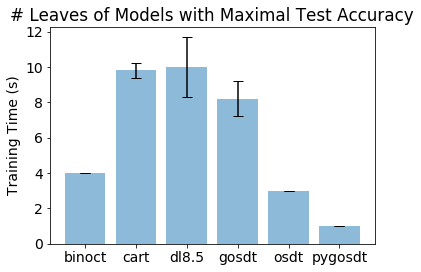

In [20]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits import mplot3d
from math import log
import pandas as pd
import numpy as np
import seaborn as sns
import re
plt.rc('font', size=14)
colors = ['#509eba', '#e3a042', '#d77ede', '#233c82', '#613717']
markers = ['o', 's', 'D', 'v', '^',]

y_axis = '# Leaves'
y_label = 'Training Time (s)'
selector = 'Test Accuracy'

for dataset in ['car-evaluation']:
    plt.figure(figsize=(8, 5), dpi=80)
    results = pd.DataFrame(pd.read_csv('../experiments/results/performance_{}.csv'.format(dataset)))
    results = results[results['Training Time'] > 0][results['Training Time'] < 300][results['# Leaves'] <= 32]

    algorithms = list(sorted(set(results['Algorithm'])))
    x_pos = list( x * 1 for x in np.arange(len(algorithms)))
    CTEs = []
    error = []

    for i, algorithm in enumerate(algorithms):
        configurations = set(zip(results['Depth Limit'], results['Width Limit'], results['Regularization']))

        selected = 0
        best_config = None
        y_mean = 0
        y_std = 0

        for config in configurations:
            (depth, width, reg) = config
            points = results[results['Algorithm']==algorithm][results['Depth Limit']==depth][results['Width Limit']==width][results['Regularization']==reg]
            if len(points) <= 0:
                continue
            # compute the y-median
            select = np.median(list(sorted([ v for v in points[selector]])))

            if select > selected:
                y_mean = np.mean(points[y_axis])
                y_std = np.std(points[y_axis])
                best_config = config
        
        CTEs.append(y_mean)
        error.append(y_std)

    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=5)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(algorithms)
    ax.set_title('{} of Models with Maximal {}'.format(y_axis, selector))

    # Save the figure and show
    plt.tight_layout()
    plt.savefig('performance_{}.png'.format(selector))
    plt.show()
